In [436]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor
from pathlib import Path

pd.set_option('display.max_columns', None)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [437]:
DATA_PATH = Path('')

# Load files
train = pd.read_csv(DATA_PATH / 'Train.csv')
test = pd.read_csv(DATA_PATH / 'Test.csv')
sample_submission = pd.read_csv(DATA_PATH / 'SampleSubmission.csv')

In [438]:
train.head()

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,sulphurdioxide_so2_slant_column_number_density,sulphurdioxide_cloud_fraction,sulphurdioxide_sensor_azimuth_angle,sulphurdioxide_sensor_zenith_angle,sulphurdioxide_solar_azimuth_angle,sulphurdioxide_solar_zenith_angle,sulphurdioxide_so2_column_number_density_15km,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,nitrogendioxide_no2_column_number_density,nitrogendioxide_tropospheric_no2_column_number_density,nitrogendioxide_stratospheric_no2_column_number_density,nitrogendioxide_no2_slant_column_number_density,nitrogendioxide_tropopause_pressure,nitrogendioxide_absorbing_aerosol_index,nitrogendioxide_cloud_fraction,nitrogendioxide_sensor_altitude,nitrogendioxide_sensor_azimuth_angle,nitrogendioxide_sensor_zenith_angle,nitrogendioxide_solar_azimuth_angle,nitrogendioxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,uvaerosollayerheight_aerosol_height,uvaerosollayerheight_aerosol_pressure,uvaerosollayerheight_aerosol_optical_depth,uvaerosollayerheight_sensor_zenith_angle,uvaerosollayerheight_sensor_azimuth_angle,uvaerosollayerheight_solar_azimuth_angle,uvaerosollayerheight_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
0,id_vjcx08sz91,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-10-25,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.052301,828817.9375,-100.805145,21.720518,-123.523796,33.745914,0.122055,2.301404,0.285803,230.693756,0.906039,-100.805145,21.720518,-123.523796,33.745914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
1,id_bkg215syli,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-02,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.045475,3771.027210,3399.756845,828569.623806,69.245351,59.159695,-143.370575,26.566997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214,1.462390,0.000240,0.359150,26.525513,-143.480164,59.220097,70.875954,-0.315206,828578.6250,70.875954,59.220097,-143.480164,26.525513,0.116975,3.049902,0.362203,228.260193,0.364713,70.875954,59.220097,-143.480164,26.525513,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2,id_oui2pot3qd,6531a46a89b3300013914a36,6.53257,3.39936,Lagos,Nigeria,2023-11-03,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.097816,828878.6875,-96.411942,61.045010,-121.307121,41.898113,0.117559,3.248703,0.384168,224.102463,0.754163,-96.411942,61.045010,-121.307121,41.898113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7

In [439]:
# Preview the first five rows of the sample submission file
sample_submission.head()

,id,pm2_5
0,id_ihxgrbq8bw,0
1,id_dg6s4fhiwe,0
2,id_f7hwwtmuzp,0
3,id_ioese5awdg,0
4,id_hdw320zpls,0


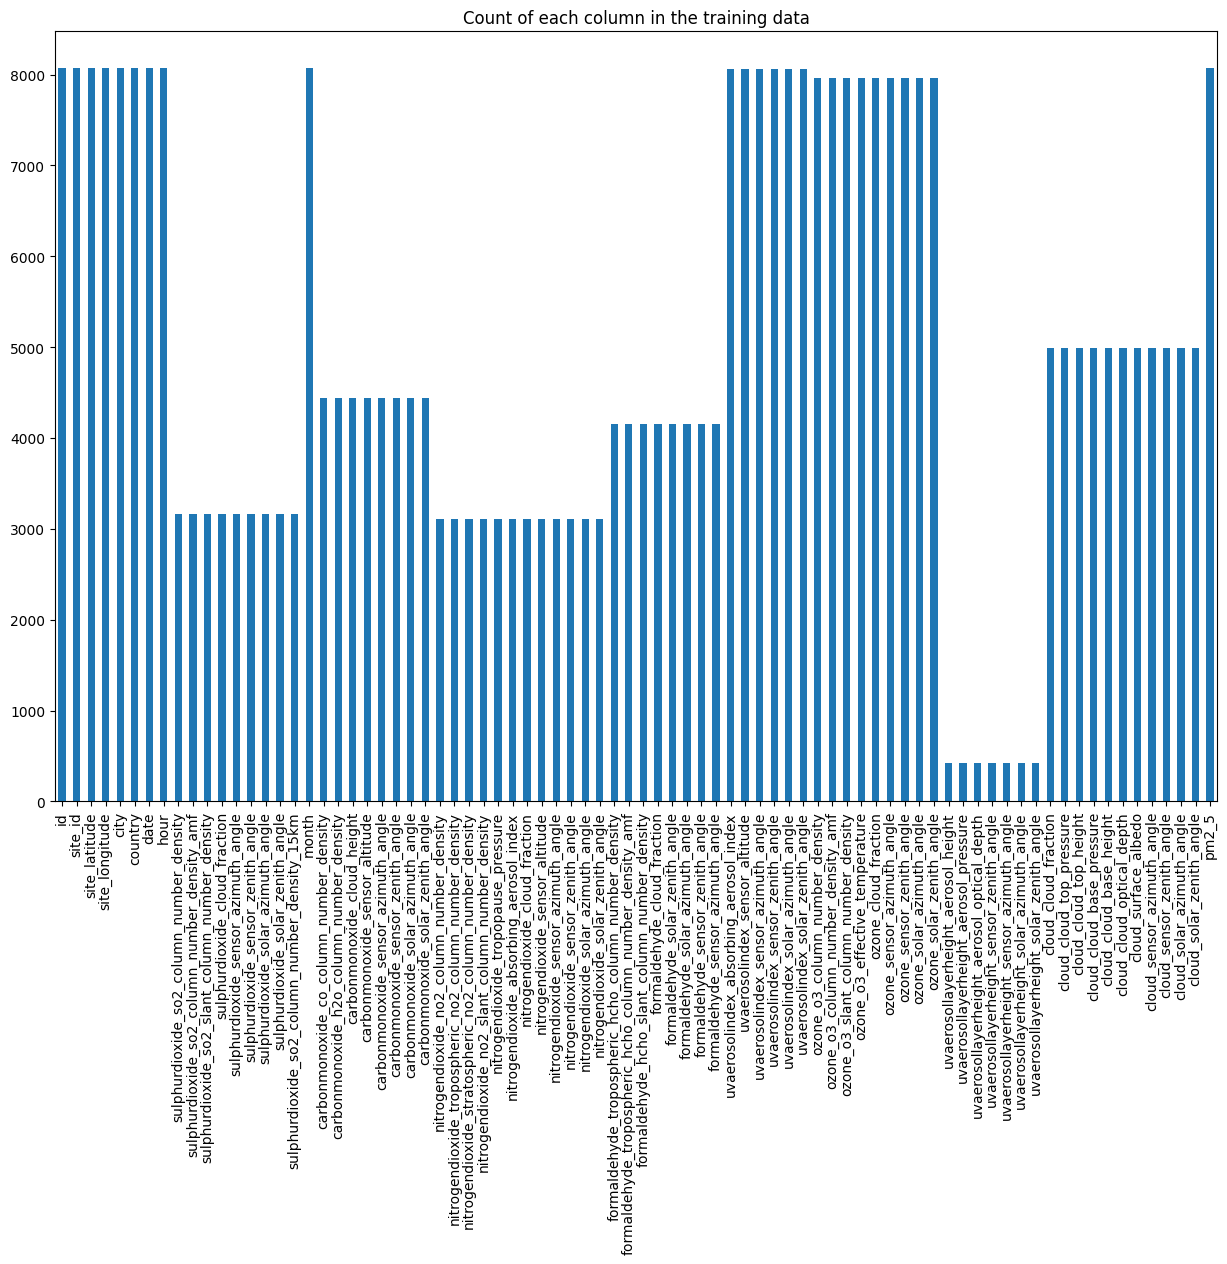

In [440]:
#plot the count of each column of the training data
train.count().plot(kind='bar', figsize=(15, 10))
plt.title('Count of each column in the training data')
plt.show()

In [441]:
#for each column, check how many non-empty rows are in the dataframe
# train.info()

#drop the columns less than 75% full
train = train.dropna(thresh=0.4*len(train), axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8071 entries, 0 to 8070
Data columns (total 52 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   id                                                        8071 non-null   object 
 1   site_id                                                   8071 non-null   object 
 2   site_latitude                                             8071 non-null   float64
 3   site_longitude                                            8071 non-null   float64
 4   city                                                      8071 non-null   object 
 5   country                                                   8071 non-null   object 
 6   date                                                      8071 non-null   object 
 7   hour                                                      8071 non-null   int64  
 8   month             

In [442]:
train.describe()

# combine city and country into one column
train['Location'] = train['country'] + ', ' + train['city']
train.drop(['country', 'city'], axis=1, inplace=True)

In [443]:
# summarise categorical variables
train.describe(include=['O'])

,id,site_id,date,Location
count,8071,8071,8071,8071
unique,8071,69,325,4
top,id_vjcx08sz91,620dd7ce72eb9200299fb8c1,2024-01-26,"Uganda, Kampala"
freq,1,288,60,5596


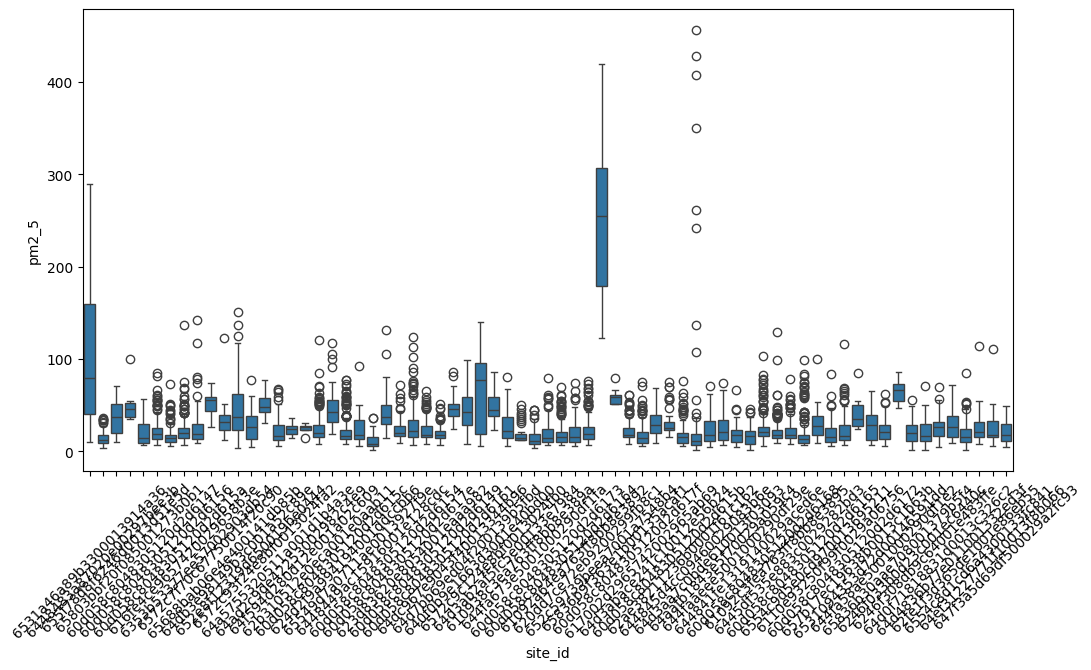

In [444]:
# show pm2_5 distributions based on the site_id
plt.figure(figsize=(12, 6))
sns.boxplot(x='site_id', y='pm2_5', data=train)
plt.xticks(rotation=45)
plt.show()

In [445]:
#drop all rows with missing values
train = train.dropna()

#count NaN values in the dataframe
train.head()

,id,site_id,site_latitude,site_longitude,date,hour,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,Location
4,id_ali5x2m4iw,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-09,13,11.0,0.049045,3514.042054,1678.370478,828902.790450,-96.099639,49.432796,-126.070747,40.144183,0.000100,1.298433,0.000068,0.223403,40.167336,-126.064468,49.513344,-97.811241,0.069669,828919.000000,-97.811241,49.513344,-126.064468,40.167336,0.117899,2.796072,0.334256,226.368851,0.226150,-97.811241,49.513344,-126.064468,40.167336,0.226141,86197.531250,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731,"Nigeria, Lagos"
9,id_02mf0t6b64,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-17,12,11.0,0.051003,2979.204248,1225.050212,828806.437312,71.570840,38.656195,-142.333301,32.405182,0.000336,1.074984,0.000295,0.075443,32.381630,-142.403336,38.779606,73.518127,0.916824,828813.937500,73.518127,38.779606,-142.403336,32.381630,0.115559,2.511124,0.296154,233.882782,0.078534,73.518127,38.779606,-142.403336,32.381630,0.075157,63377.941406,4058.409668,71396.875000,3058.409668,4.432884,0.214505,73.518120,38.779526,-142.403320,32.381641,154.909800,"Nigeria, Lagos"
11,id_stc0uavy0y,6531a46a89b3300013914a36,6.53257,3.39936,2023-11-23,12,11.0,0.046392,3539.902588,3955.364014,828805.750000,69.911583,54.143894,-148.957932,31.481571,0.000302,1.362197,0.000341,0.413242,31.501513,-148.929428,53.886005,71.619965,-0.243487,828815.000000,71.619965,53.886005,-148.929428,31.501513,0.113592,2.866768,0.331574,228.080780,0.415181,71.619965,53.886005,-148.929428,31.501513,0.415178,73086.281250,2889.231445,81258.609375,1889.231445,10.307960,0.128259,71.619957,53.885914,-148.929398,31.501530,21.050577,"Nigeria, Lagos"
18,id_il4m9rsmpi,6531a46a89b3300013914a36,6.53257,3.39936,2023-12-09,12,12.0,0.054174,2615.896973,953.316284,828974.625000,69.905113,54.145847,-153.587158,32.910831,0.000310,1.407577,0.000368,0.440821,32.863945,-153.658295,54.232574,71.571510,0.600129,828984.250000,71.578137,54.178097,-153.642388,32.874307,0.113008,2.884564,0.331596,230.421207,0.461598,71.578137,54.178097,-153.642388,32.874307,0.449181,79031.015625,2171.250977,88276.789063,1171.250977,9.900322,0.139710,71.571510,54.232479,-153.658264,32.863964,82.063000,"Nigeria, Lagos"
19,id_l2z05k2vlo,6531a46a89b3300013914a36,6.53257,3.39936,2023-12-10,13,12.0,0.059561,4444.498535,3008.956299,829242.437500,-94.263290,65.367950,-131.489853,45.456326,0.000472,0.728536,0.000285,0.268258,45.459401,-131.510547,65.307009,-95.890935,0.811503,829268.004065,-95.890935,65.307009,-131.510547,45.459401,0.114864,3.584543,0.412995,227.520580,0.269220,-95.890935,65.307009,-131.510547,45.459401,0.268351,5

In [446]:
# summarise categorical variables
train.describe(include=['O'])

# summarise the distributions of pm2_5 based on the Location variable
train.groupby('Location')['pm2_5'].describe()

,count,mean,std,min,25%,50%,75%,max
Location,,,,,,,,
"Burundi, Bujumbura",14.0,26.214557,8.918960,12.793333,17.711878,27.619625,34.087467,38.00125
"Kenya, Nairobi",371.0,18.677196,17.375050,1.496000,9.175194,15.687500,23.545096,260.90500
"Nigeria, Lagos",195.0,48.813930,52.101524,5.186600,18.524959,33.481400,59.175150,326.04475
"Uganda, Kampala",1248.0,22.189705,14.198412,5.505600,13.850008,17.643250,25.691525,142.46480


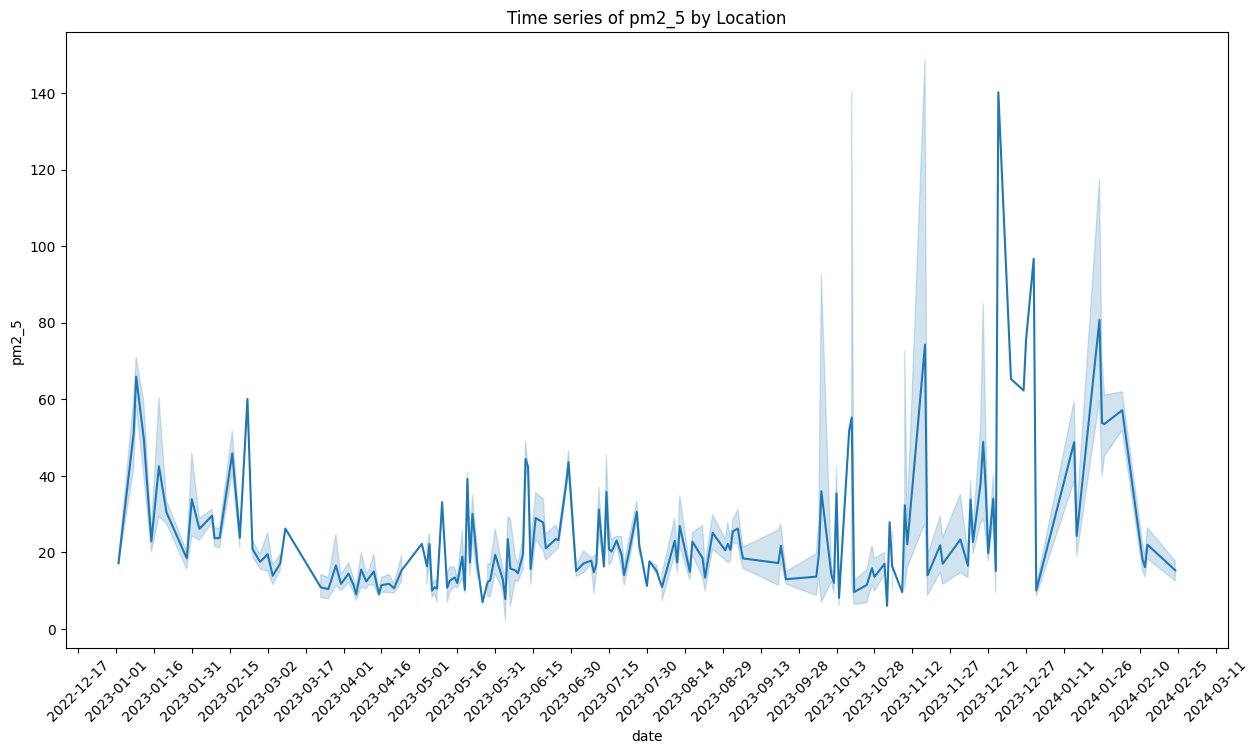

In [447]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train)

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

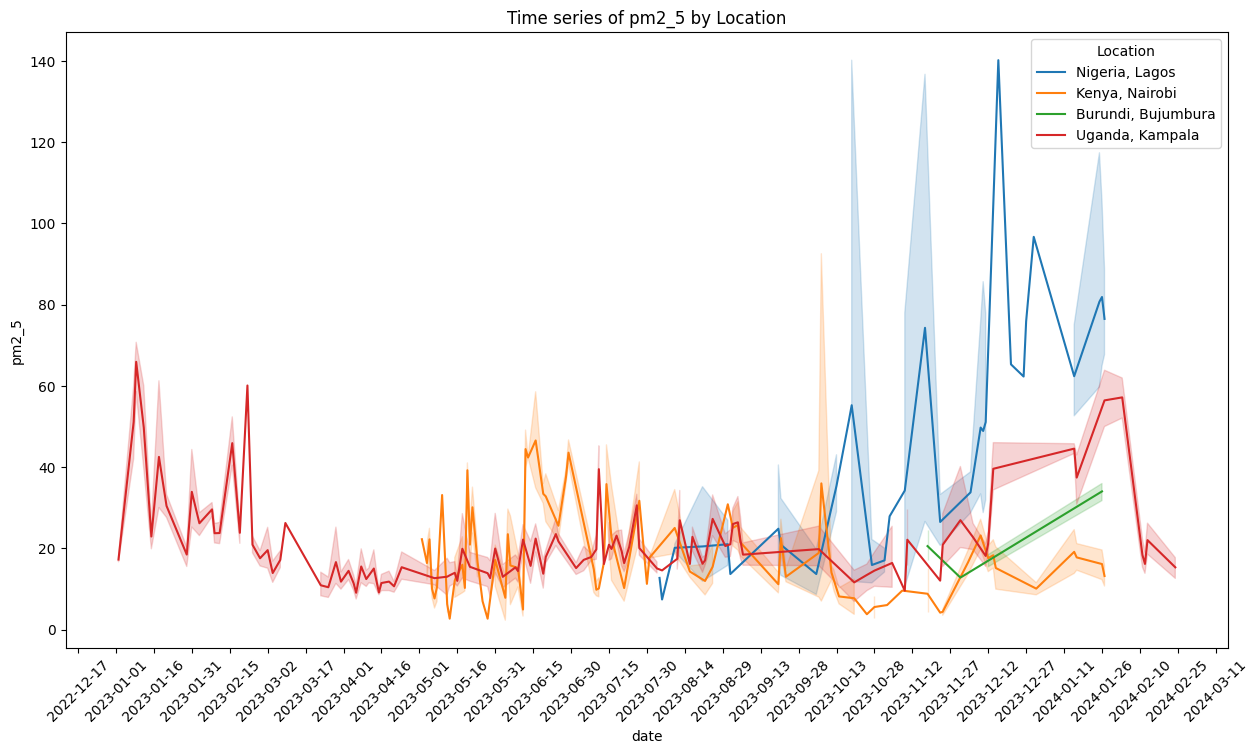

In [448]:
import matplotlib.dates as mdates

# Assume `df` is your DataFrame
train['date'] = pd.to_datetime(train['date'])

plt.figure(figsize=(15, 8))

# Create the lineplot
sns.lineplot(x='date', y='pm2_5', data=train, hue='Location')

# Set the x-ticks to be every nth date, where n is the number of days between each tick
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))  # Set interval to your liking
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Time series of pm2_5 by Location')
plt.xticks(rotation=45)  # Rotate x-tick labels for better visibility
plt.show()

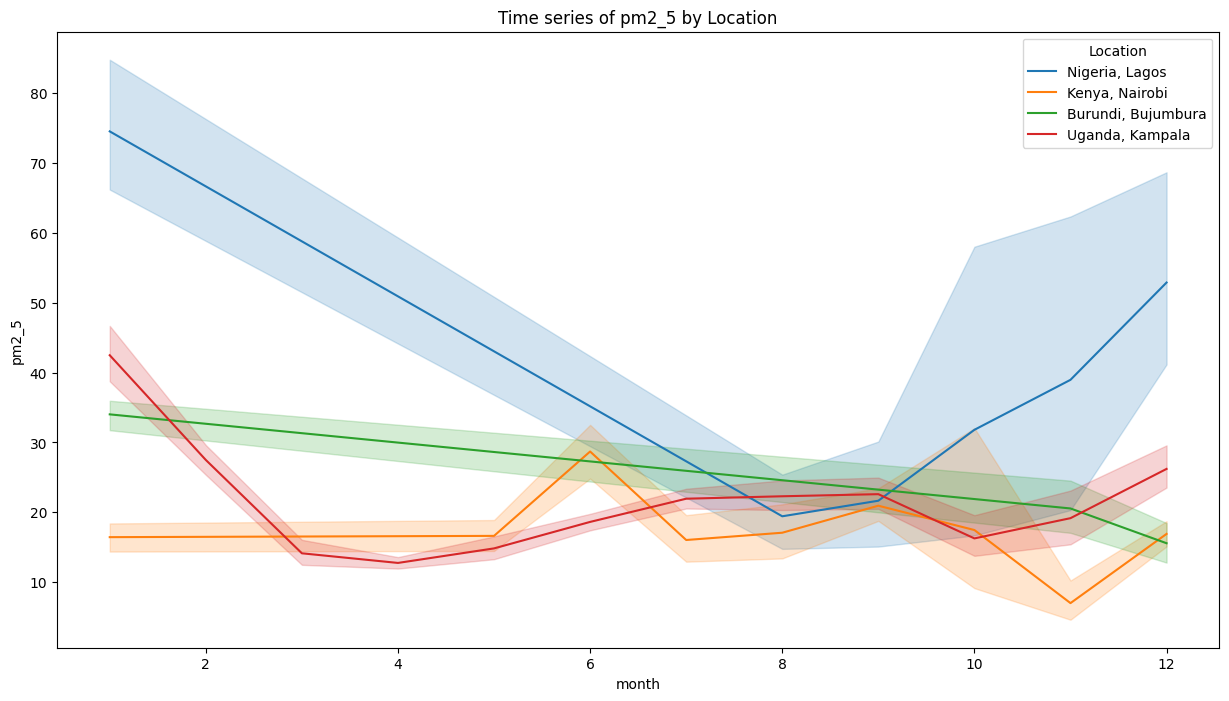

In [449]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='month', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()

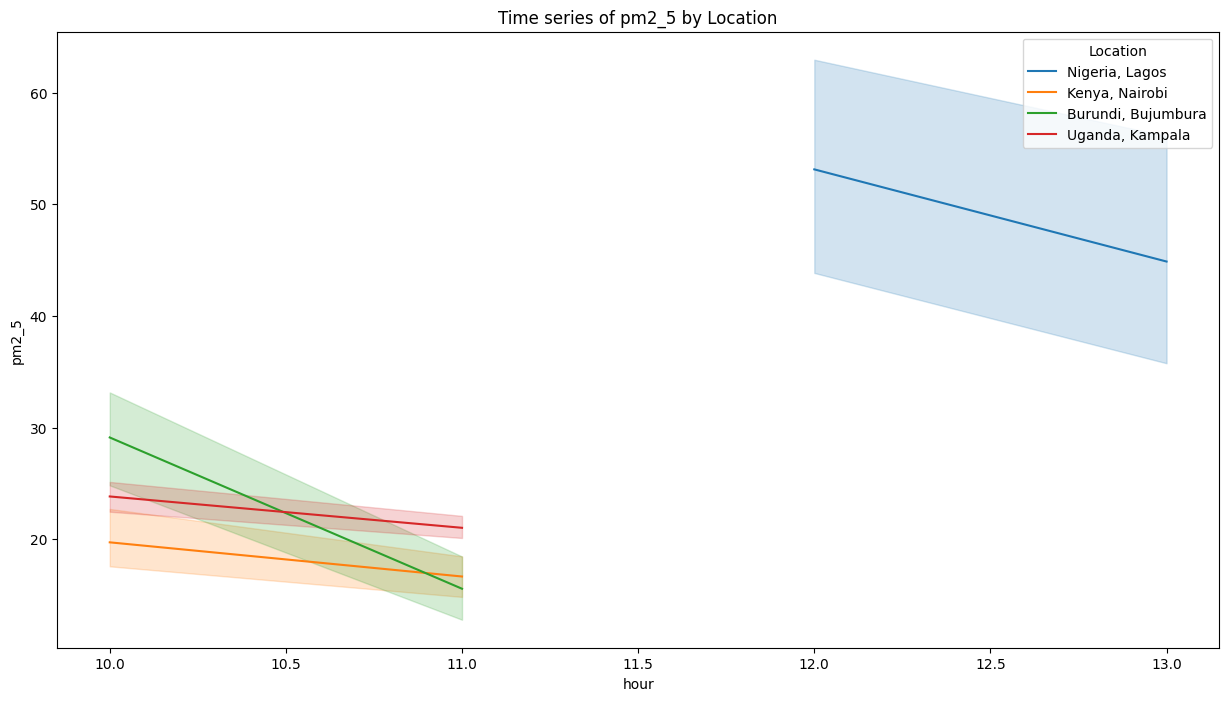

In [450]:
# lets check the correlation of date and pm2_5 using a pretty time series graph, for each location
plt.figure(figsize=(15, 8))
 
sns.lineplot(x='hour', y='pm2_5', data=train, hue='Location')
plt.title('Time series of pm2_5 by Location')
plt.show()



In [451]:
# list non-categorical columns
non_categorical = train.select_dtypes(include=[np.number]).columns
# remove hour, month, latitude and longitude from this list
non_categorical = non_categorical.drop(['hour', 'month', 'site_latitude', 'site_longitude', 'pm2_5'])
non_categorical

Index(['carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'carbonmonoxide_sensor_azimuth_angle',
       'carbonmonoxide_sensor_zenith_angle',
       'carbonmonoxide_solar_azimuth_angle',
       'carbonmonoxide_solar_zenith_angle',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density_amf',
       'formaldehyde_hcho_slant_column_number_density',
       'formaldehyde_cloud_fraction', 'formaldehyde_solar_zenith_angle',
       'formaldehyde_solar_azimuth_angle', 'formaldehyde_sensor_zenith_angle',
       'formaldehyde_sensor_azimuth_angle',
       'uvaerosolindex_absorbing_aerosol_index',
       'uvaerosolindex_sensor_altitude', 'uvaerosolindex_sensor_azimuth_angle',
       'uvaerosolindex_sensor_zenith_angle',
       'uvaerosolindex_solar_azimuth_angle',
       'uvaerosolindex_solar_zenith_angle', 'o

# Now we are training the regression model

In [452]:
# One-hot encode the 'site_id' column
train = pd.get_dummies(train, columns=['site_id'], drop_first=True)


In [453]:
# one hot encode the Location column
train = pd.get_dummies(train, columns=['Location'])

In [454]:
train.head()

,id,site_latitude,site_longitude,date,hour,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_id_652c59739beea7001a7548b4,site_id_652e8f12319d650019be0444,site_id_6531094353d72d00146591dd,site_id_6531a46a89b3300013914a36,site_id_65549d7a0711ae0013927f9e,site_id_6554c8d1cd6a4300133fc841,site_id_6554c9d5e0cd970013695211,site_id_655f78d8f6246d0013d51e5d,site_id_65688bab06e4e400141db85b,site_id_6572c7f70c67750014f20c90,site_id_6572c93f24e8bf0013024fa2,site_id_6572c9c124e8bf0013024fb0,site_id_657b17ec19638b0013c1b63b,site_id_65803bbf20f085001273b0b1,site_id_65836b30aae708001379b5f4,site_id_65836b9f363e1b00135acaf1,"Location_Burundi, Bujumbura","Location_Kenya, Nairobi","Location_Nigeria, Lagos","Location_Uganda, Kampala"
4,id_ali5x2m4iw,6.53257,3.39936,2023-11-09,13,11.0,0.049045,3514.042054,1678.370478,828902.790450,-96.099639,49.432796,-126.070747,40.144183,0.000100,1.298433,0.000068,0.223403,40.167336,-126.064468,49.513344,-97.811241,0.069669,828919.000000,-97.811241,49.

In [455]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd

# Drop the hour column
train = train.drop(columns=['hour', 'id'])

# One hot encode the
# Feature engineering
train['date'] = pd.to_datetime(train['date'])
train['day_of_week'] = train['date'].dt.dayofweek
train['day_of_month'] = train['date'].dt.day
train['year'] = train['date'].dt.year

# Drop the original 'date' column
train = train.drop(columns=['date'])
# Normalization
scaler = StandardScaler()
# scale the columns in the non-categorical columns list
train[non_categorical] = scaler.fit_transform(train[non_categorical])

train.head()


,site_latitude,site_longitude,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,site_id_60d058c8048305120d2d6149,site_id_60d058c8048305120d2d6154,site_id_60d058c8048305120d2d6156,site_id_60d058c8048305120d2d615a,site_id_60d058c8048305120d2d615b,site_id_60d058c8048305120d2d615c,site_id_60d058c8048305120d2d6161,site_id_60d058c8048305120d2d6164,site_id_60d058c8048305120d2d6165,site_id_60d058c8048305120d2d6168,site_id_60d058c8048305120d2d6172,site_id_60d058c8048305120d2d6173,site_id_60d058c8048305120d2d617e,site_id_60d058c8048305120d2d617f,site_id_61092a64ea763ff8bb8e3892,site_id_61092c3fea763ff8bb8e3895,site_id_610938c3ea763ff8bb8e389a,site_id_6110e93250f99f0029a06756,site_id_616fe4ce9657420029658b3e,site_id_617002d2965742002965ab69,site_id_620dd7ce72eb9200299fb8c1,site_id_623d83620e8054001eaaa982,site_id_6246f033b0d23c001ec6440c,site_id_6246f308db9c64001e483ffe,site_id_624d2f9a994194001ddccbb6,site_id_62ae38211236b0001f61c162,site_id_62b310512e0eca001e0aab11,site_id_62fe1f3d365de1001e86eb55,site_id_6353b53377ee57002903db54,site_id_640f0b9e1663d3001e40bd00,site_id_6445df535e883c0029282bd3,site_id_644841fe1319140029aced6e,site_id_6448449ac15916001e128cdc,site_id_644845d4cc09460029083b6e,site_id_6448483a87020e00297bee3b,site_id_644fa58ae5001000290df1e2,site_id_644fa673e5001000290df1fa,site_id_644faaeee5001000290df29e,site_id_647f3a5d69df500029a2fc93,site_id_64a5755320511a001d1b4a3e,site_id_64aafb1843e5f70029a059c4,site_id_64ad2c9de42253002982c4e9,site_id_64d0f71818831d0013c326c2,site_id_64d3aa7c0bde610013f03093,site_id_64d3ab2af5fc5e00133e7984,site_id_64d3abace241c10012e56b24,site_id_64d4836b77e011001332ed3f,site_id_64d7bb69ed04f200139b5fbd,site_id_64db3e98149b3c001a52c89e,site_id_64dc967e9043f40013344b96,site_id_64ef31227771f10013f8b066,site_id_64f594d280d12e001a02c609,site_id_652c59739beea7001a7548b4,site_id_652e8f12319d650019be0444,site_id_6531094353d72d00146591dd,site_id_6531a46a89b3300013914a36,site_id_65549d7a0711ae0013927f9e,site_id_6554c8d1cd6a4300133fc841,site_id_6554c9d5e0cd970013695211,site_id_655f78d8f6246d0013d51e5d,site_id_65688bab06e4e400141db85b,site_id_6572c7f70c67750014f20c90,site_id_6572c93f24e8bf0013024fa2,site_id_6572c9c124e8bf0013024fb0,site_id_657b17ec19638b0013c1b63b,site_id_65803bbf20f085001273b0b1,site_id_65836b30aae708001379b5f4,site_id_65836b9f363e1b00135acaf1,"Location_Burundi, Bujumbura","Location_Kenya, Nairobi","Location_Nigeria, Lagos","Location_Uganda, Kampala",day_of_week,day_of_month,year
4,6.53257,3.39936,11.0,1.258526,1.574244,-0.356210,-1.982914,-0.938762,0.374592,-0.906026,1.595872,-0.483445,0.850996,-0.289483,-0.063688,1.600413,-0.905390,0.385706,-0.932657,0.719688,-1.992040,-0.932655,0.385754,-0.905383,1.600485,0.02859

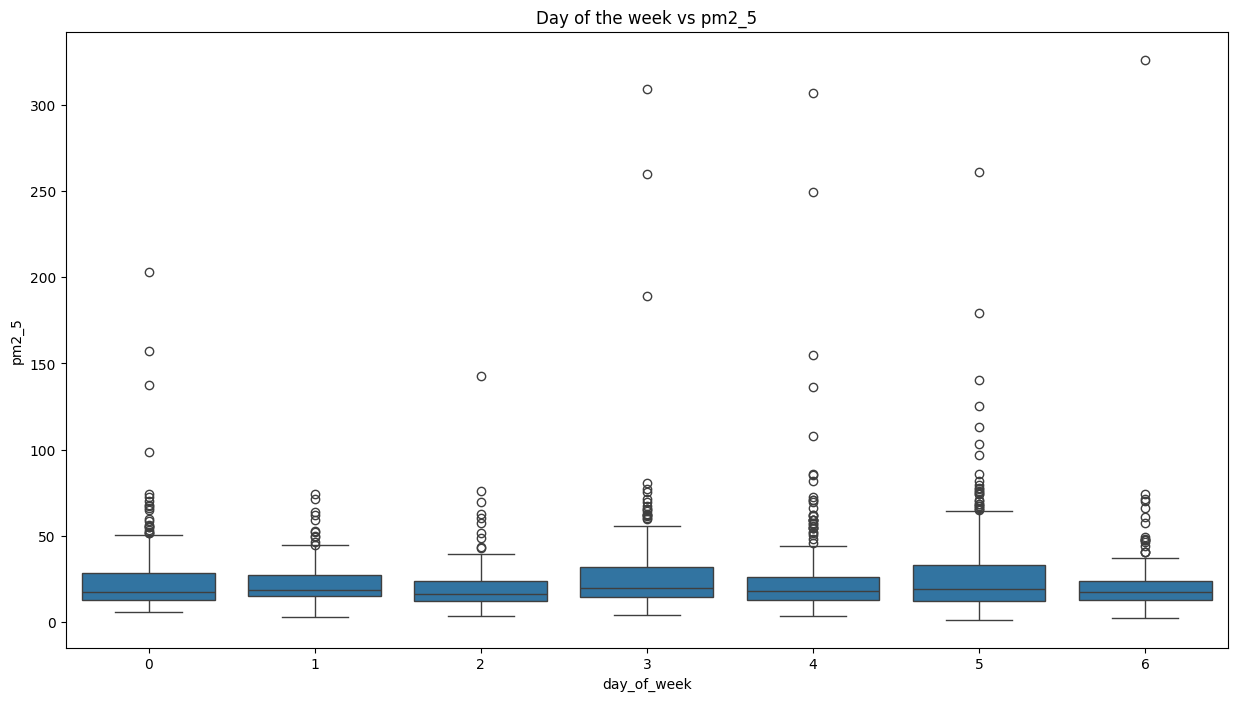

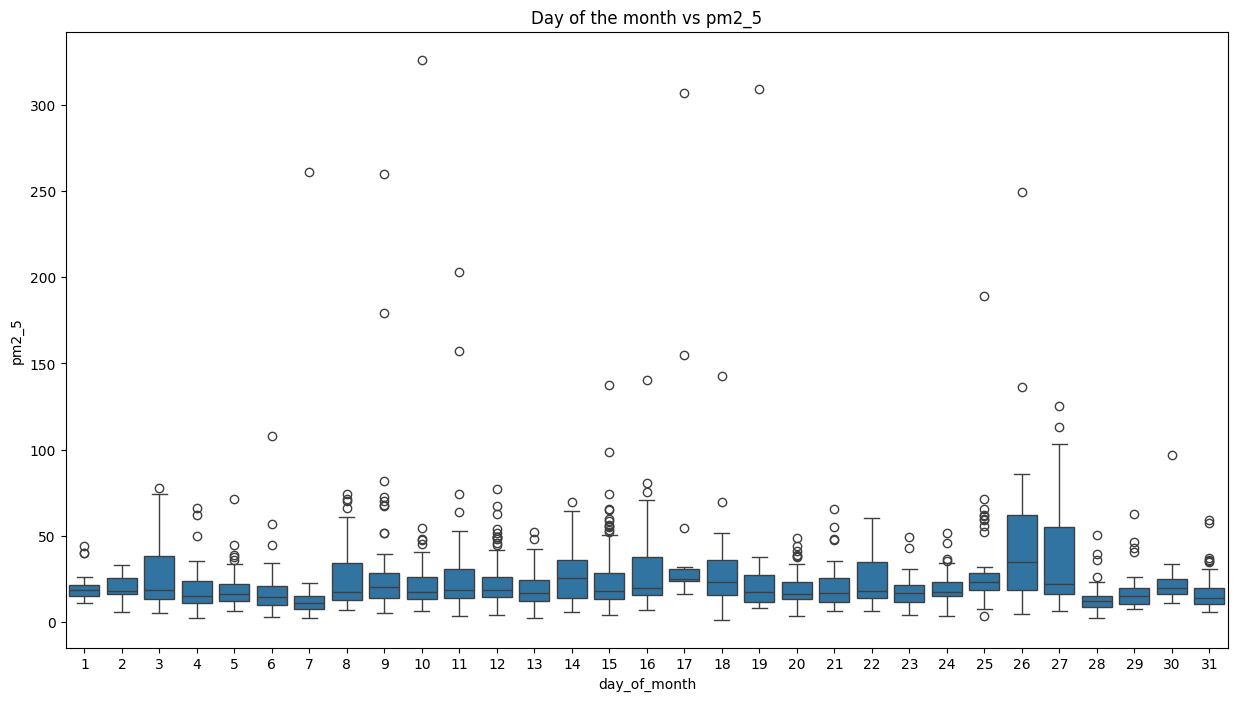

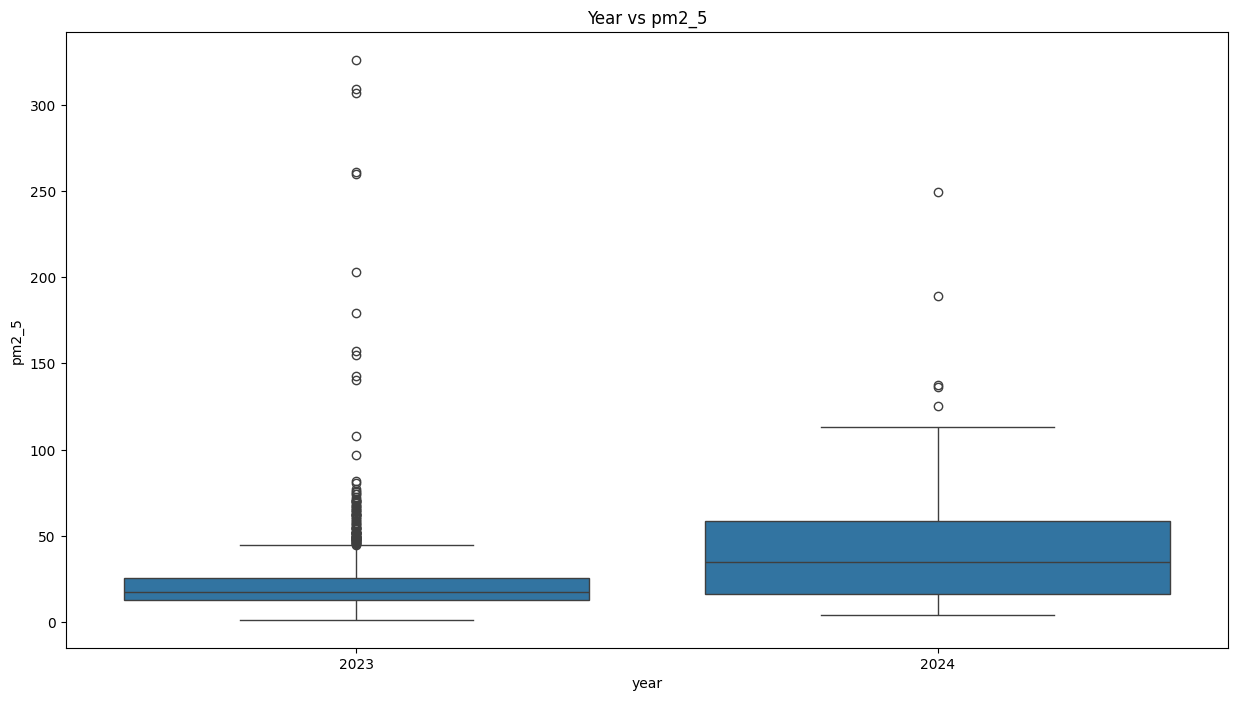

In [456]:
train.describe()

#apply transformation to pm2_5 level to reduce skewness

#plot day of the week vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_week', y='pm2_5', data=train)
plt.title('Day of the week vs pm2_5')
plt.show()

#plot day of the month vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='day_of_month', y='pm2_5', data=train)
plt.title('Day of the month vs pm2_5')
plt.show()

#plot year vs pm2_5
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='pm2_5', data=train)
plt.title('Year vs pm2_5')
plt.show()


In [457]:
# Split the data into training and testing sets
X = train.drop(columns=['pm2_5'])

y = train['pm2_5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# One hot encode the 'site_id' column

LinearRegression()

Train RMSE: 13.478775093785648
Test RMSE: 10.970583547086171


Text(0.5, 1.0, 'Actual vs Predicted values')

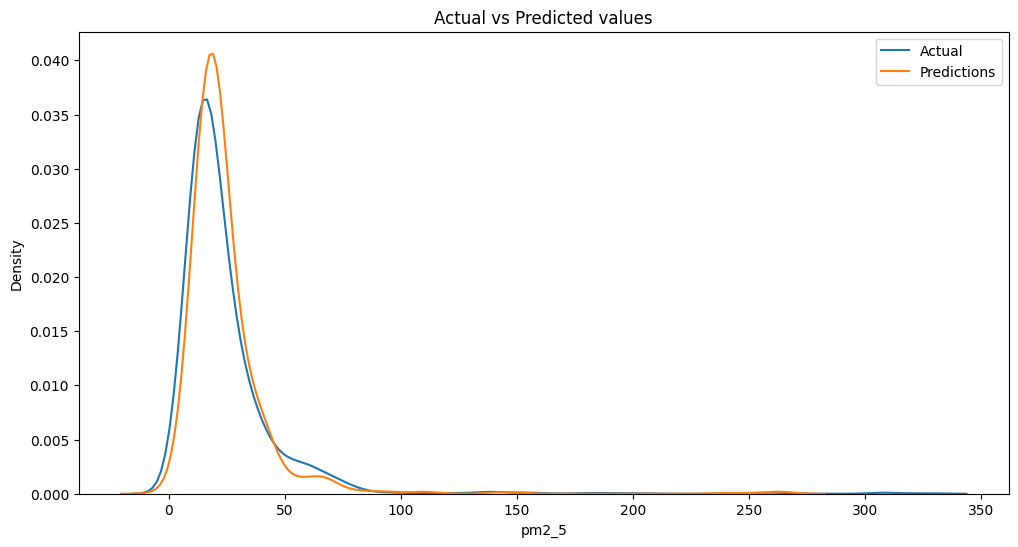

In [458]:
# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))



print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')


Epoch 1/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1651.2847 - val_loss: 279.1787
Epoch 2/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 841.0613 - val_loss: 262.7296
Epoch 3/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 794.1168 - val_loss: 266.1078
Epoch 4/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 331.0156 - val_loss: 297.0854
Epoch 5/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 787.5150 - val_loss: 231.5446
Epoch 6/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 531.0345 - val_loss: 237.4508
Epoch 7/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 506.8692 - val_loss: 228.7512
Epoch 8/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 620.3596 - val_loss: 226.3333
Epoch 9/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 462.1576 - val_loss: 217.8154
Epoch 10/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 510.0382 - val_loss: 228.4172
Epoch 11/1000
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 648.6038 - val_loss: 212.3407

Text(0.5, 1.0, 'Actual vs Predicted values')

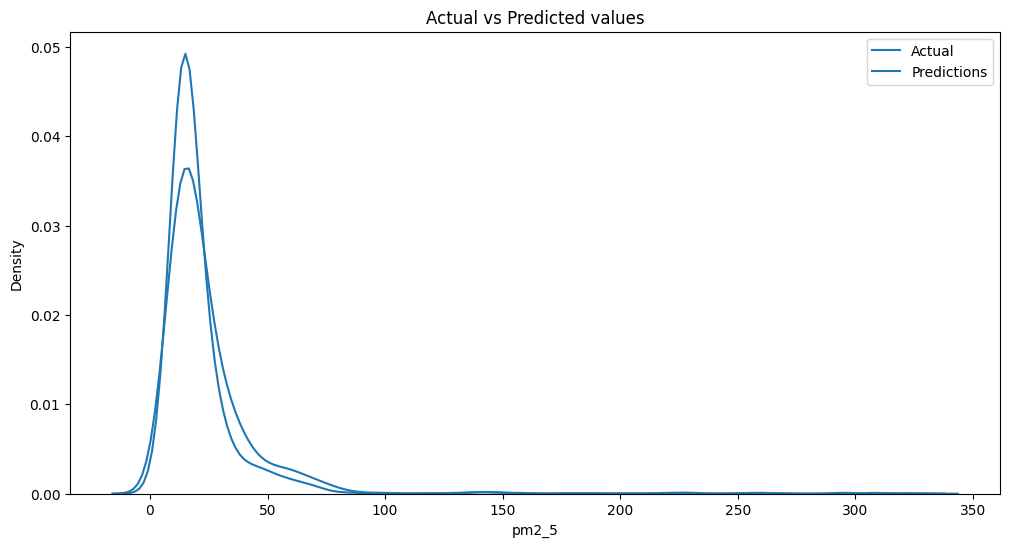

In [459]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Define the neural network architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with single node for regression

early_stop = EarlyStopping(monitor='val_loss', patience=100) 

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# assess the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# make some graphs
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Actual')
sns.kdeplot(train_preds, label='Predictions')
plt.legend()
plt.title('Actual vs Predicted values')

In [460]:
#random forest tree
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Make predictions
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

# Assess the model
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



Train RMSE: 5.171068319705972
Test RMSE: 9.902997515503955


In [461]:
X_train.columns = X_train.columns.str.replace('[^a-zA-Z0-9_]', '_', regex=True)

In [462]:
model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10960
[LightGBM] [Info] Number of data points in the train set: 1462, number of used features: 84
[LightGBM] [Info] Start training from score 24.529053
Local RMSE: 10.480890088354535


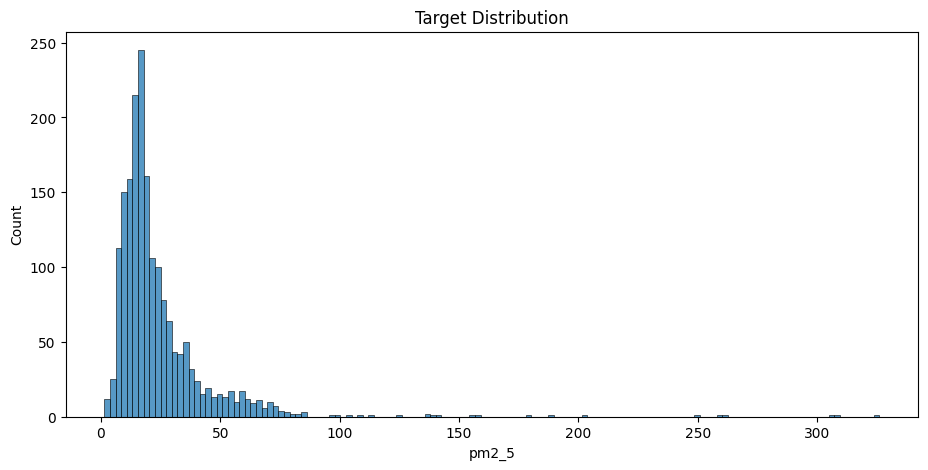

In [463]:

# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train.pm2_5)
plt.title('Target Distribution')
plt.show()

- From the target distribution histogram we can see that the distribution is skewed to the right.
- Some processing of the target is recommended

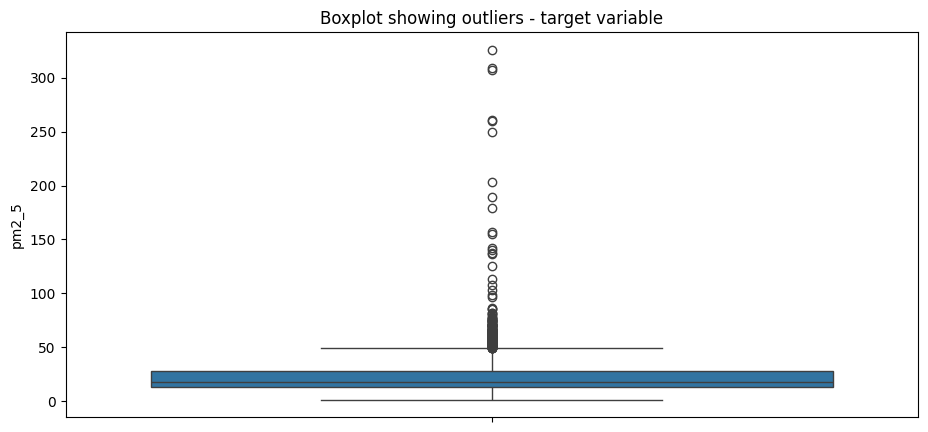

In [464]:
# Check for outliers in the target variable
plt.figure(figsize = (11, 5))
sns.boxplot(train.pm2_5)
plt.title('Boxplot showing outliers - target variable')
plt.show()

- The target variable has some outliers that are beyond the 180 mark.
- Outliers can be handled via
  - Dropping them
  - Cap outliers - set a maximum
  - Assign a new value to the outliers
  - Transform the target variable


In [465]:
# print a summary of each variable
train.describe()

,site_latitude,site_longitude,month,carbonmonoxide_co_column_number_density,carbonmonoxide_h2o_column_number_density,carbonmonoxide_cloud_height,carbonmonoxide_sensor_altitude,carbonmonoxide_sensor_azimuth_angle,carbonmonoxide_sensor_zenith_angle,carbonmonoxide_solar_azimuth_angle,carbonmonoxide_solar_zenith_angle,formaldehyde_tropospheric_hcho_column_number_density,formaldehyde_tropospheric_hcho_column_number_density_amf,formaldehyde_hcho_slant_column_number_density,formaldehyde_cloud_fraction,formaldehyde_solar_zenith_angle,formaldehyde_solar_azimuth_angle,formaldehyde_sensor_zenith_angle,formaldehyde_sensor_azimuth_angle,uvaerosolindex_absorbing_aerosol_index,uvaerosolindex_sensor_altitude,uvaerosolindex_sensor_azimuth_angle,uvaerosolindex_sensor_zenith_angle,uvaerosolindex_solar_azimuth_angle,uvaerosolindex_solar_zenith_angle,ozone_o3_column_number_density,ozone_o3_column_number_density_amf,ozone_o3_slant_column_number_density,ozone_o3_effective_temperature,ozone_cloud_fraction,ozone_sensor_azimuth_angle,ozone_sensor_zenith_angle,ozone_solar_azimuth_angle,ozone_solar_zenith_angle,cloud_cloud_fraction,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5,day_of_week,day_of_month,year
count,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.000000,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1.828000e+03,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.644407,30.312814,6.110503,3.886995e-17,0.000000,-9.328789e-17,-1.899419e-13,1.554798e-17,3.206771e-16,5.830493e-18,-1.136946e-16,-1.992085e-17,-2.098977e-16,-3.886995e-17,-1.360448e-17,3.799538e-16,-4.081345e-17,3.673211e-16,-1.554798e-17,1.943498e-17,1.103907e-15,7.773991e-18,-2.098977e-16,-2.098977e-16,-3.770385e-16,2.161169e-15,6.899417e-16,-2.244740e-16,1.480945e-15,3.109596e-17,7.773991e-17,3.070726e-16,1.807453e-16,8.551390e-17,1.943498e-18,4.664394e-16,9.328789e-17,4.431175e-16,3.886995e-17,6.996591e-17,-5.014224e-16,5.441793e-17,1.807453e-16,-2.798637e-16,1.515928e-16,24.347764,3.161926,14.927790,2023.115974
std,2.150439,9.472133,3.431373,1.000274e+00,1.000274,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,1.000274e+00,23.689122,2.007385,8.366943,0.320281
min,-3.459970,3.201510,1.000000,-1.569840e+00,-1.791603,-1.709298e+00,-2.835153e+00,-9.632543e-01,-2.835868e+00,-1.711413e+00,-2.368779e+00,-3.131329e+00,-2.424427e+00,-3.847872e+00,-1.864013e+00,-2.384084e+00,-1.712895e+00,-2.833067e+00,-9.891029e-01,-2.464396e+00,-2.855909e+00,-9.890868e-01,-2.832805e+00,-1.712889e+00,-2.384067e+00,-2.815989e+00,-1.618931e+00,-2.288997e+00,-3.207625e+00,-1.756417e+00,-9.890868e-01,-2.832803e+00,-1.712893e+00,-2.384052e+00,-1.734965e+00,-2.973352e+00,-1.775666e+00,-3.057926e+00,-1.622754e+00,-1.560546e+00,-3.675573e+00,-9.890236e-01,-2.832839e+00,-1.711631e+00,-2.385356e+00,1.496000,0.000000,1.000000,2023.000000
25%,0.288630,32.569800,3.000000,-6.342900e-01,-0.661147,-7.007

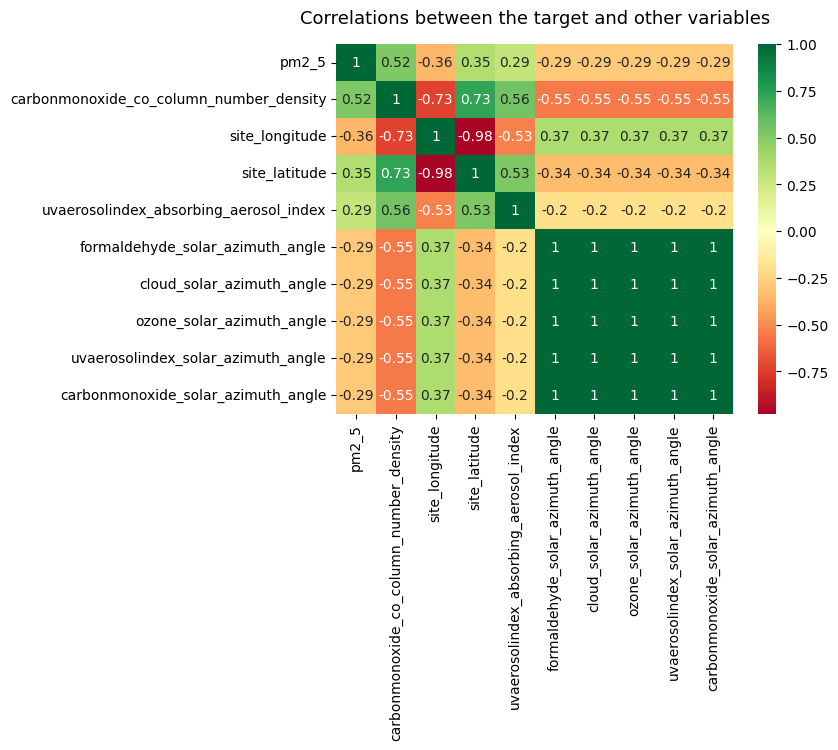

In [466]:
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])

top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).head(10)
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 13})
plt.show()

In [467]:
# Select X and y features for modelling
X = train_num_df.drop('pm2_5', axis = 1)
y = train.pm2_5

test_df = test[X.columns]
test_df.head()

KeyError: "['day_of_week', 'day_of_month', 'year'] not in index"

In [ ]:
train.head()

In [ ]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LGBMRegressor()
model.fit(X_train, y_train)

# Local score
y_pred = model.predict(X_test)

score = mean_squared_error(y_test, y_pred, squared=False)
print('Local RMSE:', score)

In [ ]:
# Make predictions on the test set
preds = model.predict(test_df)

# Create submission file
sub = pd.DataFrame({'id': test['id'], 'pm2_5': preds})

# Preview sub file
sub.head()

In [ ]:
# Create a csv file
sub.to_csv('submission.csv', index = False)